In [1]:
import numpy as np
from scipy import stats
from rich.pretty import pprint
from matplotlib import pyplot as plt
from dataclasses import dataclass
from sigpyproc.viz.styles import set_seaborn

import loki
from pyloki.detection import schemes
from pyloki.detection import thresholding

In [2]:
branching_pattern = np.array([8.        , 3.        , 2.        , 3.        , 3.        ,
       1.        , 6.        , 3.        , 1.        , 1.        ,
       3.        , 1.        , 1.        , 3.        , 3.        ,
       3.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 3.        , 1.        , 3.        ,
       3.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 3.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 3.        ,
       1.        , 1.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       3.        , 1.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.94441882, 1.54287748, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 2.        ])

nparam_vol = 2**10.67 #1
nstages = len(branching_pattern)
ntrials = 2**10
nparams = 4
target_snr = 10.0
ref_ducy = 0.1
nbins = 64
ducy_max = 0.2

bp_log10 = np.log10(np.prod(branching_pattern))
print(f"bp (log10) = {bp_log10:.2f}")
print(f"snr target (tree) = {stats.norm.isf(10**(-(bp_log10))):.2f}")
print(f"snr target (trees) = {stats.norm.isf(10**(-(bp_log10 + np.log10(nparam_vol)))):.2f}")
print(f"snr target (trees+freq) = {stats.norm.isf(10**(-(bp_log10 + np.log10(nparam_vol) + 3))):.2f}")
print(f"snr target (trees+freq+dm) = {stats.norm.isf(10**(-(bp_log10 + np.log10(nparam_vol) + 3 + 2))):.2f}")

bp (log10) = 13.86
snr target (tree) = 7.61
snr target (trees) = 8.51
snr target (trees+freq) = 9.28
snr target (trees+freq+dm) = 9.76


### Dynamic thresholding

In [3]:
#dyn = loki.thresholds.DynamicThresholdScheme(branching_pattern, ref_ducy, nbins, ntrials=ntrials, nprobs=30, prob_min=0.05, snr_final=target_snr,
#                                             nthresholds=100, ducy_max=ducy_max, beam_width=2.0, nthreads=8)
#with loki.libloki.ostream_redirect(stdout=True, stderr=True):
#    dyn.run(thres_neigh=10)
#results_file = dyn.save(outdir="schemes/circular/")

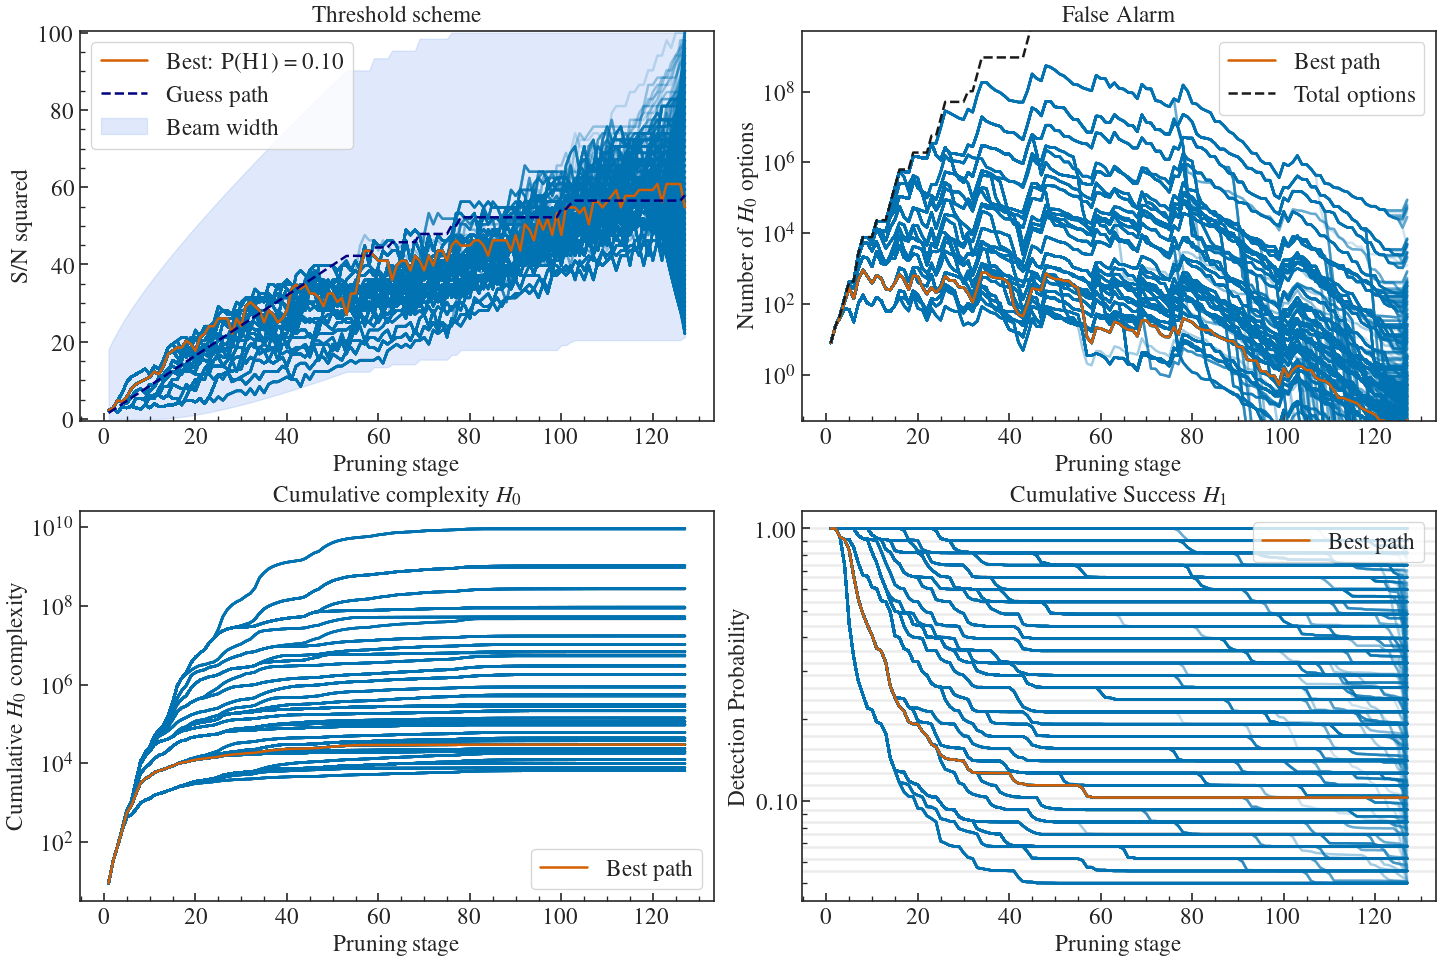

In [4]:
#dyn_results = thresholding.DynamicThresholdSchemeAnalyser.from_file(results_file)
dyn_results = schemes.DynamicThresholdSchemeAnalyser.from_file("schemes/circular/dynscheme_nstages_127_nthresh_100_nprobs_030_ntrials_1024_snr_10.0_ducy_0.10_beam_3.0.h5")

set_seaborn(use_latex=True, **{"lines.linewidth": 1.5})
fig, _ = dyn_results.plot_paths(best_prob=0.1, min_prob=0.001)
best_path = dyn_results.backtrack_best(min_probs=[0.1])
#plt.savefig("figures/thresholding_dynamic_snap.pdf", dpi=300)
plt.show()

### Plot comparison

In [12]:
bound_scheme  = schemes.bound_scheme(nstages, target_snr)
trials_scheme = schemes.trials_scheme(branching_pattern, 1)
minimized_scheme = np.minimum(bound_scheme, trials_scheme)
probs = 1 / branching_pattern
probs[:15] = 1
constant_scheme = thresholding.determine_scheme(probs, branching_pattern, ref_ducy, nbins, ntrials=ntrials, snr_final=target_snr, ducy_max=ducy_max)
best_path, best_path_3, best_path_5 = dyn_results.backtrack_best(min_probs=[0.1, 0.3, 0.5])

schemes_dict = {"bound": bound_scheme, "min": minimized_scheme, "constant": constant_scheme.thresholds, "dyn_0.5": best_path_5.thresholds,
                "dyn_0.3": best_path_3.thresholds, "dyn_best": best_path.thresholds}
states_dict  = {key: thresholding.evaluate_scheme(thresh_scheme, branching_pattern, ref_ducy, nbins, ntrials=ntrials, snr_final=target_snr, ducy_max=ducy_max)
               for key, thresh_scheme in schemes_dict.items()}

In [13]:
from dataclasses import dataclass

@dataclass
class SchemeLabels:
    scheme: thresholding.StatesInfo
    name: str
    color: str
    ls: str


states = [
    SchemeLabels(states_dict["bound"], "bound", "tab:orange", "-"),
    SchemeLabels(states_dict["min"], "min(bound, trials)", "navy", "--"),
    SchemeLabels(states_dict["constant"], "constant", "tab:red", "-"),
    SchemeLabels(states_dict["dyn_0.5"], "dyn_0.5", "skyblue", "-"),
    SchemeLabels(states_dict["dyn_0.3"], "dyn_0.3", "dodgerblue", "-"),
    SchemeLabels(states_dict["dyn_best"], "dyn_best", "tab:blue", "-"),             
]

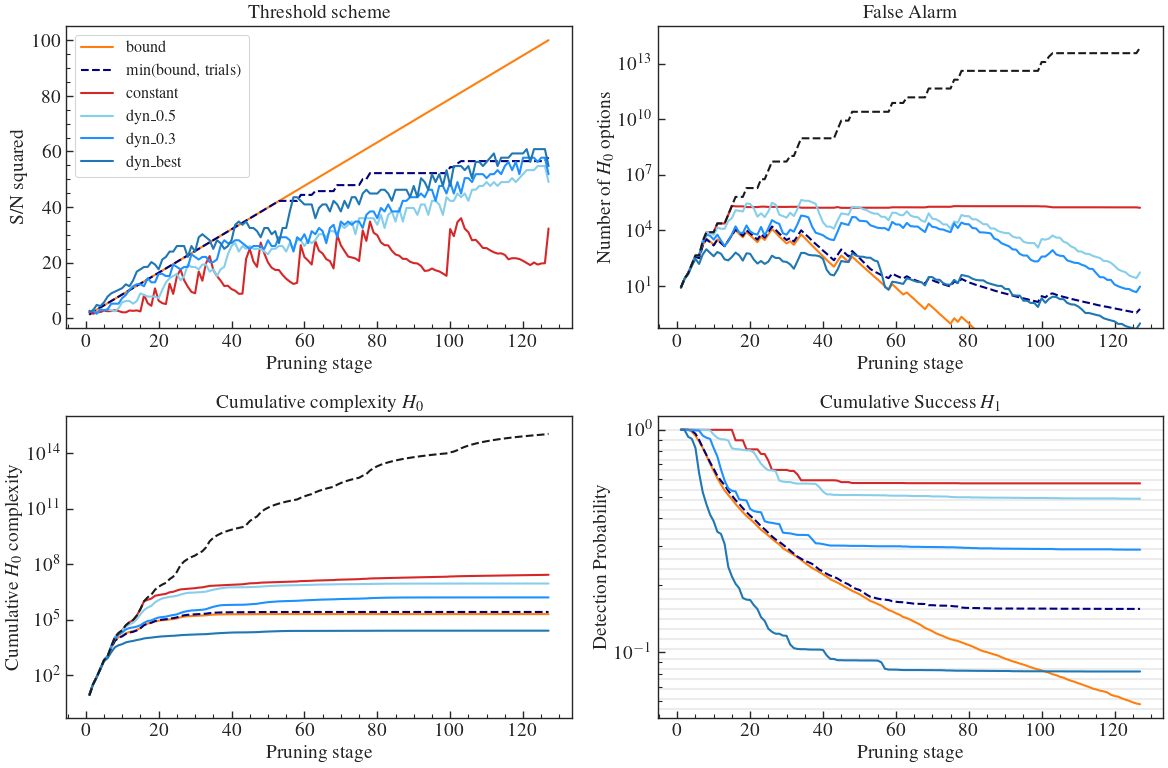

In [14]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 8))
x = np.arange(1, len(branching_pattern) + 1)

for state in states:
    ax1.plot(x, state.scheme.thresholds**2, label=state.name, c=state.color, ls=state.ls)
    ax2.plot(x, state.scheme.get_info("complexity"), label=state.name, c=state.color, ls=state.ls)
    ax3.plot(x, state.scheme.get_info("complexity_cumul"), label=state.name, c=state.color, ls=state.ls)
    ax4.plot(x, state.scheme.get_info("success_h1_cumul"), label=state.name, c=state.color, ls=state.ls)
ax1.set_xlabel("Pruning stage")
ax1.set_ylabel("S/N squared")
ax1.set_title("Threshold scheme")
ax1.legend(fontsize="small")
ax2.set_xlabel("Pruning stage")
ax2.set_ylabel(r"Number of $H_{0}$ options")
ax2.set_title("False Alarm")
ax2.set_yscale("log")
ax3.set_xlabel("Pruning stage")
ax3.set_ylabel(r"Cumulative $H_{0}$ complexity")
ax3.set_title(r"Cumulative complexity $H_{0}$")
ax3.set_yscale("log")
ax4.set_xlabel("Pruning stage")
ax4.set_ylabel("Detection Probability")
ax4.set_title(r"Cumulative Success $H_{1}$")
ax4.set_yscale("log")

ax2_current_ylim = ax2.get_ylim()
ax2.plot(x, np.cumprod(branching_pattern), color="k", ls="--", label="Total options")
ax2.set_ylim(bottom=0.05, top=10**15)#top=ax2_current_ylim[1])
ax3_current_ylim = ax3.get_ylim()
ax3.plot(x, np.cumsum(np.cumprod(branching_pattern)), color="k", ls="--", label="Total options")
ax3.set_ylim(bottom=0.5, top=10**16)#top=ax3_current_ylim[1])
for pval in dyn_results.probs[1:]:
    ax4.axhline(y=pval, color="gray", alpha=0.15, linestyle="-", zorder=0)
plt.tight_layout()
#plt.savefig("figures/thresholding_dynamic_snap_comparison.pdf", dpi=300)
plt.show()

In [15]:
states_dict['dyn_best'].print_summary()

Branching Pattern: [8.0,3.0,2.0,3.0,3.0,1.0,6.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,
 3.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,
 1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,
 1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,
 1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
 1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.9,1.5,1.0,1.0,1.0,1.0,1.0,
 1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
 2.0]

Thresholds: [1.5,1.7,2.2,2.1,2.4,2.8,3.0,3.1,3.2,3.3,3.5,3.4,3.7,4.1,4.2,4.3,4.3,4.5,
 4.4,4.2,4.6,4.7,4.9,4.9,5.1,5.1,5.1,4.7,5.1,4.9,5.4,5.5,5.4,5.3,5.0,5.3,
 5.2,5.0,5.1,5.3,5.8,5.9,5.8,5.9,5.7,5.7,5.6,5.4,5.7,5.7,5.5,5.6,5.2,5.7,
 5.7,6.2,6.6,6.6,6.5,6.4,6.4,6.4,6.0,6.3,6.4,6.4,6.2,6.5,6.4,6.2,6.5,6.3,
 6.6,6.6,6.4,6.7,6.8,6.7,6.7,6.7,6.8,6.8,6.7,6.5,6.8,6.8,6.8,6.8,6.6,6.9,
 6.6,7.1,7.0,6.8,7.2,7.0,7.2,6.9,7.3,6.9,7.4,7.4,7.4,7.3,7.4,7.1,7.5,7.5,
 7.4,7.5,7.6,7.7,7.4,7.6,7.6,7.6,7.7,7.7,7.7,7.7,7.8,7.5,7.8,7.8,7.8,7.8,
 7.4]

         Scheme Metrics Summary         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                       ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Branching mean               │  1.29 │
│ Branching max                │  8.00 │
│ Total enumerated options     │ 46.04 │
│ Pruning complexity           │ 14.65 │
│ Crude survival probability   │  0.08 │
│ Total cost                   │ 18.26 │
│ Number of independent trials │ 17.16 │
│ Total survival probability   │  0.77 │
└──────────────────────────────┴───────┘

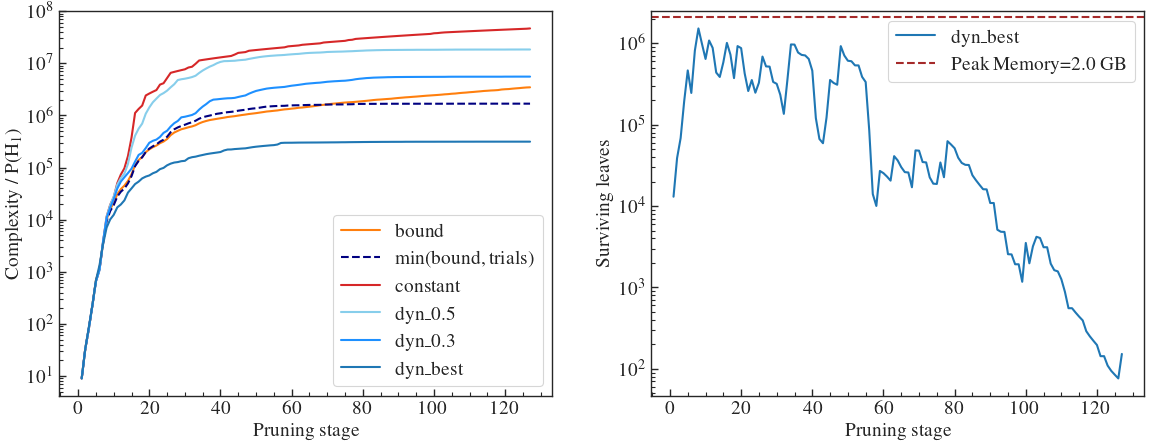

In [16]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
for state in states:
    ax1.plot(x, state.scheme.get_info("cost"), label=state.name, c=state.color, ls=state.ls)
    if state.name=="dyn_best":
        ax2.plot(x, state.scheme.get_info("complexity") * nparam_vol, label=state.name, c=state.color, ls=state.ls)
ax1.set_xlabel("Pruning stage")
ax1.set_ylabel("Complexity / P(H$_{1}$)")
ax1.set_yscale("log")
ax1.legend()
ax2.set_xlabel("Pruning stage")
ax2.set_ylabel("Surviving leaves")
ax2.set_yscale("log")
sugg_max = 2**21
peak_memory = np.log2(sugg_max) + np.log2(2*nbins) + 3
ax2.axhline(sugg_max, ls="--", color="brown", label=f"Peak Memory={2**(peak_memory - 30):.1f} GB")
ax2.legend()
#plt.savefig("figures/thresholding_dynamic_snap_cost.pdf", dpi=300)
plt.show()

In [17]:
thresholds = np.around(best_path.thresholds, decimals=1)
thresholds

array([1.5, 1.7, 2.2, 2.1, 2.4, 2.8, 3. , 3.1, 3.2, 3.3, 3.5, 3.4, 3.7,
       4.1, 4.2, 4.3, 4.3, 4.5, 4.4, 4.2, 4.6, 4.7, 4.9, 4.9, 5.1, 5.1,
       5.1, 4.7, 5.1, 4.9, 5.4, 5.5, 5.4, 5.3, 5. , 5.3, 5.2, 5. , 5.1,
       5.3, 5.8, 5.9, 5.8, 5.9, 5.7, 5.7, 5.6, 5.4, 5.7, 5.7, 5.5, 5.6,
       5.2, 5.7, 5.7, 6.2, 6.6, 6.6, 6.5, 6.4, 6.4, 6.4, 6. , 6.3, 6.4,
       6.4, 6.2, 6.5, 6.4, 6.2, 6.5, 6.3, 6.6, 6.6, 6.4, 6.7, 6.8, 6.7,
       6.7, 6.7, 6.8, 6.8, 6.7, 6.5, 6.8, 6.8, 6.8, 6.8, 6.6, 6.9, 6.6,
       7.1, 7. , 6.8, 7.2, 7. , 7.2, 6.9, 7.3, 6.9, 7.4, 7.4, 7.4, 7.3,
       7.4, 7.1, 7.5, 7.5, 7.4, 7.5, 7.6, 7.7, 7.4, 7.6, 7.6, 7.6, 7.7,
       7.7, 7.7, 7.7, 7.8, 7.5, 7.8, 7.8, 7.8, 7.8, 7.4], dtype=float32)

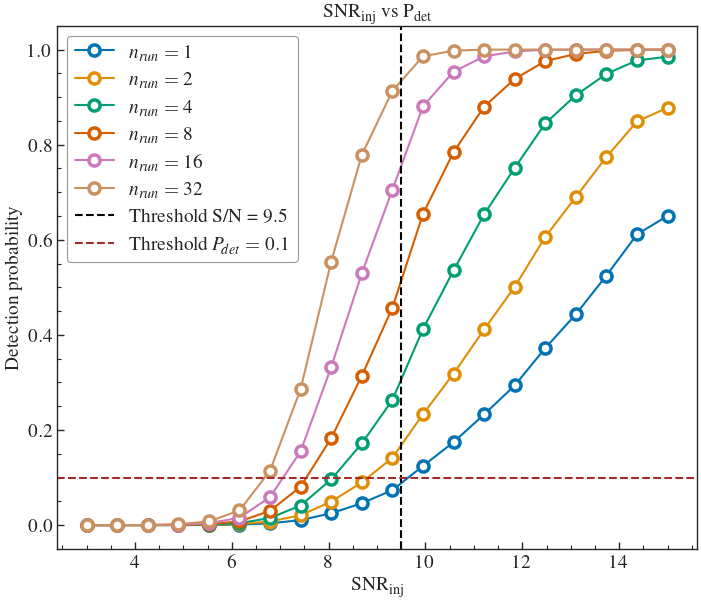

In [15]:
n_runs_arr = np.array([1, 2, 4, 8, 16, 32])
snr_injs = np.linspace(3, 15, 20)
det_prob_arr = np.zeros((len(n_runs_arr), len(snr_injs)))
for i_snr in range(len(snr_injs)):
    thresh_state_eval = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=ref_ducy, nbins=nbins, ntrials=ntrials, snr_final=snr_injs[i_snr],
                                                     ducy_max=ducy_max, wtsp=1.1)
    det_prob = thresh_state_eval.get_info("success_h1_cumul")[-1]
    for i_run in range(len(n_runs_arr)):
        det_prob_arr[i_run][i_snr] = 1 - (1 - det_prob) ** n_runs_arr[i_run]
fig, ax = plt.subplots(figsize=(7,6), dpi=100, constrained_layout=True)
for i, n in enumerate(n_runs_arr):
    ax.plot(snr_injs, det_prob_arr[i], marker="o", ms=8, mfc="w", mew=2.5, label=f"$n_{{run}}={n}$")
ax.axvline(target_snr, ls="--", color="black", label=f"Threshold S/N = {target_snr:.1f}")
ax.axhline(0.1, ls="--", color="brown", label="Threshold $P_{det}=0.1$")
ax.set_xlabel(r"SNR$_{\mathrm{inj}}$")
ax.set_ylabel("Detection probability")
ax.set_title(r"SNR$_{\mathrm{inj}}$ vs P$_{\mathrm{det}}$")
ax.legend(frameon=True, edgecolor="gray")
#plt.savefig("figures/thresholding_dynamic_snap_detection.pdf", dpi=300)
plt.show()